# Summary

The code to wrangle the data.  Deal with NAs, join data frames, etc.

In [2]:
# Setup Notebook
import os
if os.path.basename(os.getcwd()) != "mtg-modeling":
    get_ipython().run_line_magic("run", '-i "../../scripts/notebook_header.py"')  # type: ignore

Changed working directory to: d:\mtg-modeling


In [3]:
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import polars as pl

In [4]:
paths = {
    "raw": Path("data/raw/17lands/game_data/PremierDraft"),
    "interim": Path("data/interim/17lands/game_data/premier_draft"),
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}


In [13]:
csv_file = paths["raw"] / "game_data_public.BLB.PremierDraft.csv"
parquet_file = paths["interim"] / "game_data_public.BLB.PremierDraft.parquet"

os.makedirs(paths["interim"], exist_ok=True)
os.makedirs(paths["processed"], exist_ok=True)

In [14]:
df_lazy = pl.scan_csv(csv_file)
df_lazy.collect().write_parquet(parquet_file)

In [15]:

df_lazy = pl.scan_parquet(parquet_file)   # 680,000 rows; 1,400 columns
cols = df_lazy.collect_schema().names()

status_prefixes = ['tutored_', 'deck_', 'opening_', 'drawn_', 'sideboard_']
card_cols = [col for col in cols if any([col.startswith(s) for s in status_prefixes])]
index_cols = [col for col in cols if col not in card_cols]
index_cols

results = []
chunk_size = 10000
num_rows = df_lazy.select(pl.count()).collect().item()


for i in tqdm(range(0, num_rows+1, chunk_size)):
    df_chunk = df_lazy.slice(i, chunk_size).unpivot(
        on=card_cols,
        index=index_cols,
        variable_name='card',
        value_name='count',
    ).with_columns(
        pl.col("card").str.extract(r"(.*)_.*").alias("status"),
        pl.col("card").str.extract(r".*_(.*)").alias("name")
    ).drop("card").collect().pivot(
        on="status",
        values="count",
    )

    results.append(df_chunk)

df_final = pl.concat(results)

print(df_final.shape)

C:\Users\Josh.Meehl\AppData\Local\Temp\ipykernel_32344\2848365151.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  num_rows = df_lazy.select(pl.count()).collect().item()


  0%|          | 0/68 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
# Read the first 5 lines of the CSV file
df = pd.read_csv(csv_file, nrows=100)
parquet_file_100 = paths["interim"] / "game_data_public.BLB.PremierDraft_100.parquet"
df.to_parquet(parquet_file_100)
df.head()

,expansion,event_type,draft_id,draft_time,game_time,build_index,match_number,game_number,rank,opp_rank,...,"tutored_Ygra, Eater of All","deck_Ygra, Eater of All","sideboard_Ygra, Eater of All","opening_hand_Zoraline, Cosmos Caller","drawn_Zoraline, Cosmos Caller","tutored_Zoraline, Cosmos Caller","deck_Zoraline, Cosmos Caller","sideboard_Zoraline, Cosmos Caller",user_n_games_bucket,user_game_win_rate_bucket
0,BLB,PremierDraft,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 22:58:45,0,1,1,gold,NaN,...,0,1,0,0,0,0,0,0,10,0.54
1,BLB,PremierDraft,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 23:13:12,0,2,1,gold,NaN,...,0,1,0,0,0,0,0,0,10,0.54
2,BLB,PremierDraft,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 23:29:06,0,3,1,gold,NaN,...,0,1,0,0,0,0,0,0,10,0.54
3,BLB,PremierDraft,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 23:46:30,0,4,1,gold,NaN,...,0,1,0,0,0,0,0,0,10,0.54
4,BLB,PremierDraft,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 23:55:34,0,5,1,gold,NaN,...,0,1,0,0,0,0,0,0,10,0.54


In [21]:
cols = df.columns.to_list()
open_cols = cols[:cols.index('won')+1] + cols[-2:]
deck_cols = [col for col in cols if 'deck' in col]
open_cols = open_cols + deck_cols
print(len(open_cols), len(cols))
open_cols[:5]

296 1400


['expansion', 'event_type', 'draft_id', 'draft_time', 'game_time']

In [22]:
deck_cols[:5]

['deck_Agate Assault',
 'deck_Agate-Blade Assassin',
 "deck_Alania's Pathmaker",
 'deck_Alania, Divergent Storm',
 "deck_Artist's Talent"]

In [19]:
read_csv = False

if read_csv:

    file_size = parquet_file.stat().st_size
    file_size_100 = Path(parquet_file_100).stat().st_size

    # Estimate the number of chunks
    num_rows = (file_size / file_size_100) * 100 // 1
    print(num_rows)

    mem = df.memory_usage(deep=True).sum() * num_rows / 100 // 1 / 1e9
    print(mem)

    # Define the chunk size
    chunk_size = 10000  # Adjust based on your memory capacity

    # Estimate the number of chunks
    num_chunks = num_rows // chunk_size + 15
    print(num_chunks)

    # Create an empty list to store chunks
    chunks = []

    # Read the CSV file in chunks
    for i, chunk in enumerate(tqdm(pd.read_csv(f'{filebase}.csv', usecols=open_cols, chunksize=chunk_size), total=num_chunks, desc="Processing CSV")):
        chunks.append(chunk)

    df = pd.concat(chunks)
    df.reset_index(drop=True, inplace=True)
    df.to_parquet(parquet_file)

else:
    df = pd.read_parquet(parquet_file)

NameError: name 'filebase' is not defined

In [6]:
df.columns[:20]

Index(['expansion', 'event_type', 'draft_id', 'draft_time', 'game_time',
       'build_index', 'match_number', 'game_number', 'rank', 'opp_rank',
       'main_colors', 'splash_colors', 'on_play', 'num_mulligans',
       'opp_num_mulligans', 'opp_colors', 'num_turns', 'won',
       'deck_Abraded Bluffs', 'deck_Abrupt Decay'],
      dtype='object')

In [7]:
# Collect the columns that are card names
deck_cols = [col for col in df.columns if 'deck_' in col]
len(deck_cols)

381

In [8]:
# Count the cards in each deck
deck_counts = df[deck_cols].sum(axis=1)
count_density = deck_counts.value_counts().sort_index() / len(deck_counts)

In [9]:
deck_counts_adj = pd.concat([deck_counts, pd.Series(np.arange(deck_counts.min(), deck_counts.max() + 1))])

In [10]:
deck_counts_adj.value_counts()

40    1099461
41      62610
42       5664
43       2224
44        842
45        647
46        344
47        206
50        125
48        105
49         43
53         35
51         30
52         21
60         19
55         10
54          9
69          6
57          5
59          4
72          4
65          1
70          1
68          1
67          1
66          1
58          1
64          1
63          1
62          1
61          1
56          1
71          1
Name: count, dtype: int64

In [11]:
deck_cols

['deck_Abraded Bluffs',
 'deck_Abrupt Decay',
 'deck_Akul the Unrepentant',
 'deck_Aloe Alchemist',
 'deck_Ambush Gigapede',
 'deck_Ancient Cornucopia',
 'deck_Anguished Unmaking',
 'deck_Ankle Biter',
 'deck_Annie Flash, the Veteran',
 'deck_Annie Joins Up',
 'deck_Another Round',
 'deck_Archangel of Tithes',
 'deck_Archive Trap',
 "deck_Archmage's Charm",
 "deck_Archmage's Newt",
 'deck_Arid Archway',
 'deck_Armored Armadillo',
 'deck_Assimilation Aegis',
 'deck_At Knifepoint',
 'deck_Aven Interrupter',
 'deck_Back for More',
 'deck_Badlands Revival',
 "deck_Bandit's Haul",
 'deck_Baron Bertram Graywater',
 'deck_Beastbond Outcaster',
 'deck_Bedevil',
 'deck_Betrayal at the Vault',
 'deck_Binding Negotiation',
 'deck_Blacksnag Buzzard',
 'deck_Blood Hustler',
 'deck_Blooming Marsh',
 'deck_Boneyard Desecrator',
 'deck_Bonny Pall, Clearcutter',
 'deck_Boom Box',
 'deck_Botanical Sanctum',
 'deck_Bounding Felidar',
 'deck_Bovine Intervention',
 'deck_Brazen Borrower',
 'deck_Breeches, 

In [12]:
big_mask = deck_counts == 57
df_big = df[big_mask]
df_big[deck_cols].iloc[0].sort_values(ascending=False).head(50), df_big[deck_cols].iloc[0].sum()

(deck_Plains                          6
 deck_Mountain                        6
 deck_Island                          6
 deck_Wanted Griffin                  3
 deck_Razzle-Dazzler                  2
 deck_Eriette's Lullaby               2
 deck_Thunder Salvo                   2
 deck_Deadeye Duelist                 2
 deck_Irascible Wolverine             1
 deck_Shepherd of the Clouds          1
 deck_Hellspur Brute                  1
 deck_Thunder Lasso                   1
 deck_Jem Lightfoote, Sky Explorer    1
 deck_Bridled Bighorn                 1
 deck_Iron-Fist Pulverizer            1
 deck_Abraded Bluffs                  1
 deck_Outlaw Medic                    1
 deck_Geralf, the Fleshwright         1
 deck_Slickshot Vault-Buster          1
 deck_Hypothesizzle                   1
 deck_Rodeo Pyromancers               1
 deck_Stop Cold                       1
 deck_Stingerback Terror              1
 deck_Sterling Keykeeper              1
 deck_Phantom Interference            1


AttributeError: Line2D.set() got an unexpected keyword argument 'discrete'

<Figure size 400x300 with 0 Axes>

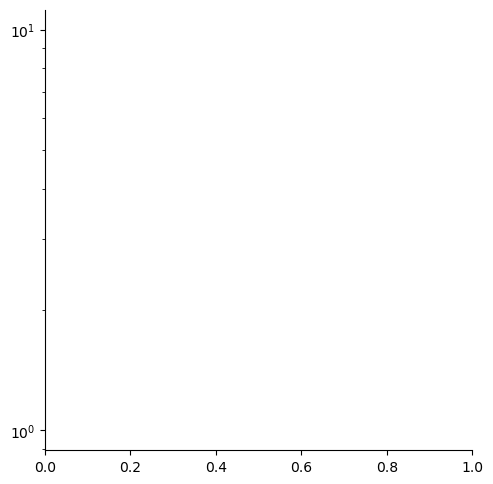

In [13]:
# Plot deck card count histo
plt.figure(figsize=(4, 3))
sns.displot(deck_counts_adj, discrete=True, stat='percent', log_scale=[False, True], element='bars', kind='ecdf');

(array([9.67097317e-01, 5.50715769e-02, 4.98123816e-03, 1.95537567e-03,
        7.39753009e-04, 5.68228828e-04, 3.01706638e-04, 1.80320294e-04,
        9.14795636e-05, 3.69436699e-05, 1.09071787e-04, 2.55087245e-05,
        1.75922238e-05, 2.99067804e-05, 7.03688951e-06, 7.91650070e-06,
        0.00000000e+00, 3.51844475e-06, 0.00000000e+00, 2.63883357e-06,
        1.58330014e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.39805594e-06, 0.00000000e+00, 0.00000000e+00,
        2.63883357e-06]),
 array([40.        , 40.96969697, 41.93939394, 42.90909091, 43.87878788,
        44.84848485, 45.81818182, 46.78787879, 47.75757576, 48.72727273,
        49.6969697 , 50.66666667, 51.63636364, 52.60606061, 53.57575758,
        54.54545455, 55.51515152, 56.48484848, 57.45454545, 58.42424242,
        59.39393939, 60.36363636, 61.33333333, 62.3030303 , 63.27272727,
        64.24242424, 65.21212121,

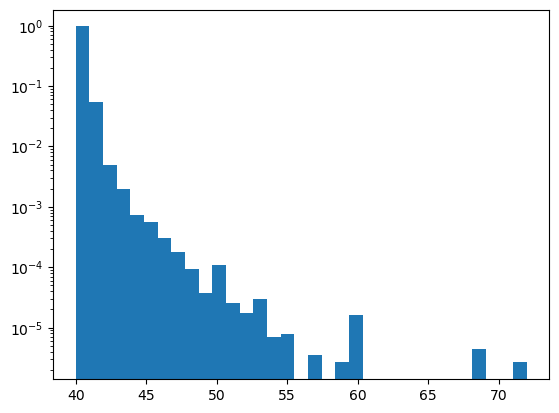

In [ ]:
plt.hist(deck_counts, bins=deck_counts.max() - deck_counts.min() + 1, density=True, log=True)

In [ ]:
deck_mask = deck_counts < 43
df = df[deck_mask]
df[deck_cols].max().max()

NameError: name 'deck_counts' is not defined

In [ ]:
col = 'deck_Worldwalker Helm'
mem = df.memory_usage(deep=True).sum() / 1e9
print(mem)
df[deck_cols] = df[deck_cols].astype('int8')
mem = df.memory_usage(deep=True).sum() / 1e9
print(mem)

0.899973878
0.899973878


In [ ]:
df.head()

,expansion,event_type,build_index,match_number,game_number,rank,opp_rank,main_colors,splash_colors,on_play,...,Visage Bandit,Void Rend,Voidslime,Voracious Varmint,Vraska Joins Up,"Vraska, the Silencer",Wanted Griffin,Worldwalker Helm,Wrangler of the Damned,"Wylie Duke, Atiin Hero"
0,OTJ,PremierDraft,0,1,1,bronze,NaN,WU,B,False,...,1,0,0,0,0,0,0,0,2,0
1,OTJ,PremierDraft,0,2,1,bronze,NaN,WU,B,True,...,1,0,0,0,0,0,0,0,2,0
2,OTJ,PremierDraft,0,3,1,silver,NaN,WU,B,True,...,1,0,0,0,0,0,0,0,2,0
3,OTJ,PremierDraft,0,4,1,silver,NaN,WU,B,True,...,1,0,0,0,0,0,0,0,2,0
4,OTJ,PremierDraft,0,5,1,silver,NaN,WU,B,True,...,1,0,0,0,0,0,0,0,2,0


In [ ]:
ids = pd.DataFrame(df['draft_id'].unique()).reset_index(drop=False)
ids.columns = ['draft_index', 'draft_id']
mem = df.memory_usage(deep=True).sum() / 1e9
print(mem)
df = df.merge(ids, on='draft_id', how='left')
df.drop(columns=['draft_id', 'draft_time', 'game_time'], inplace=True)
mem = df.memory_usage(deep=True).sum() / 1e9
print(mem)

KeyError: 'draft_id'

In [ ]:
df.to_feather(f'{filebase}.feather')
mem = df.memory_usage(deep=True).sum() / 1e9
print(mem)
df = pd.read_feather(f'{filebase}.feather')
mem = df.memory_usage(deep=True).sum() / 1e9
print(mem)

0.899973878
0.899973878


In [ ]:
df = pd.read_feather(f'{filebase}.feather')

In [ ]:
deck_cols = [col for col in df.columns if 'deck_' in col]
non_deck_cols = [col for col in df.columns if col not in deck_cols]
df = df[non_deck_cols + deck_cols]
deck_cols = [col[5:] for col in deck_cols]
df.columns = non_deck_cols + deck_cols
df.columns.to_list()

['expansion',
 'event_type',
 'build_index',
 'match_number',
 'game_number',
 'rank',
 'opp_rank',
 'main_colors',
 'splash_colors',
 'on_play',
 'num_mulligans',
 'opp_num_mulligans',
 'opp_colors',
 'num_turns',
 'won',
 'user_n_games_bucket',
 'user_game_win_rate_bucket',
 'draft_idx',
 'Abraded Bluffs',
 'Abrupt Decay',
 'Akul the Unrepentant',
 'Aloe Alchemist',
 'Ambush Gigapede',
 'Ancient Cornucopia',
 'Anguished Unmaking',
 'Ankle Biter',
 'Annie Flash, the Veteran',
 'Annie Joins Up',
 'Another Round',
 'Archangel of Tithes',
 'Archive Trap',
 "Archmage's Charm",
 "Archmage's Newt",
 'Arid Archway',
 'Armored Armadillo',
 'Assimilation Aegis',
 'At Knifepoint',
 'Aven Interrupter',
 'Back for More',
 'Badlands Revival',
 "Bandit's Haul",
 'Baron Bertram Graywater',
 'Beastbond Outcaster',
 'Bedevil',
 'Betrayal at the Vault',
 'Binding Negotiation',
 'Blacksnag Buzzard',
 'Blood Hustler',
 'Blooming Marsh',
 'Boneyard Desecrator',
 'Bonny Pall, Clearcutter',
 'Boom Box',
 'B

In [ ]:
df.to_feather(f'../../data/OTJ/deck.feather')